### Import packeges

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import time
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
import joblib 
from pathlib import Path
import xgboost as xgb


In [6]:
# Define functions to calculate NDVI and NDWI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-10)

def calculate_ndwi(nir, swir):
    return (nir - swir) / (nir + swir + 1e-10)

# Function to extract mean NDVI & NDWI as features
def extract_features(image_path):
    with rasterio.open(image_path) as src:
        bands = src.read()
        nir, red, swir = bands[3], bands[2], bands[4]  # Adjust based on band order
        
        ndvi = calculate_ndvi(nir, red)
        ndwi = calculate_ndwi(nir, swir)

        return [np.mean(ndvi), np.mean(ndwi)]  # Use mean as feature

In [7]:
# Load dataset efficiently
train_dataset_path = Path('../../../data/model/Patches/Train/')
test_dataset_path = Path('../../../data/model/Patches/Test/')
growth_stages = ["germination", "tillering", "grand_growth", "ripening"]
X, X_test, y, y_test = [], [], [], []

for idx, stage in enumerate(growth_stages):
    stage_path = train_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X.append(extract_features(img_path))
        y.append(idx)

X = np.array(X)
y = np.array(y)

for idx, stage in enumerate(growth_stages):
    stage_path = test_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X_test.append(extract_features(img_path))
        y_test.append(idx)

X_test = np.array(X_test)
y_test = np.array(y_test)

#### Apply k-Fold Cross-Validation and GridSearchCV

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
[0]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[1]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[2]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[3]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[4]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[5]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[6]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[7]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[8]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629


c:\Users\user\anaconda3\envs\research_env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[10]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[11]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[12]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[13]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[14]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[15]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[16]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[17]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[18]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[19]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[20]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[21]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[22]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[23]	validation_0-mlogloss:1.38629	validation_1-mlogloss:1.38629
[24]	validation_0-mlogloss

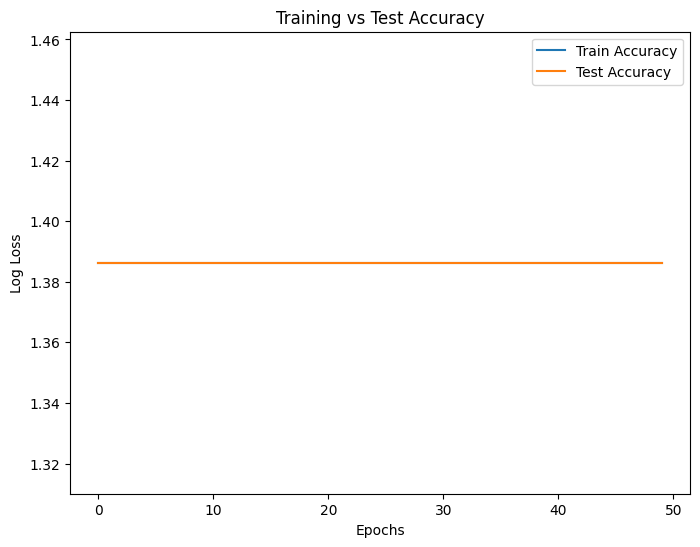

In [17]:
# Define parameter grid for XGBoost
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Initialize XGBoost and GridSearchCV
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(xgb_model, param_grid, cv=kf, n_jobs=-1, verbose=2, return_train_score=True)

# Train model with cross-validation
grid_search.fit(X, y)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Train the model on the entire training dataset
history = best_model.fit(X, y, eval_set=[(X, y), (X_test, y_test)], verbose=True)

# Plot training and test accuracy
eval_results = best_model.evals_result()
train_accuracy = eval_results['validation_0']['mlogloss']
test_accuracy = eval_results['validation_1']['mlogloss']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.savefig(Path("../../../logs/IMG/NEW/XGB_V1_accuracy_plot.png"))
plt.show()

#### Evaluate Model

c:\Users\user\anaconda3\envs\research_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\research_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\research_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Test Accuracy: 0.25
Test Precision: 0.0625
Test Recall: 0.25
Test F1 Score: 0.1
Classification Report:
              precision    recall  f1-score   support

           0       0.25      1.00      0.40      2071
           1       0.00      0.00      0.00      2071
           2       0.00      0.00      0.00      2071
           3       0.00      0.00      0.00      2071

    accuracy                           0.25      8284
   macro avg       0.06      0.25      0.10      8284
weighted avg       0.06      0.25      0.10      8284

Saved model to: ..\..\..\models\Map\xgb_model_v1.joblib
Best Cross-Validation Accuracy: 21.71%


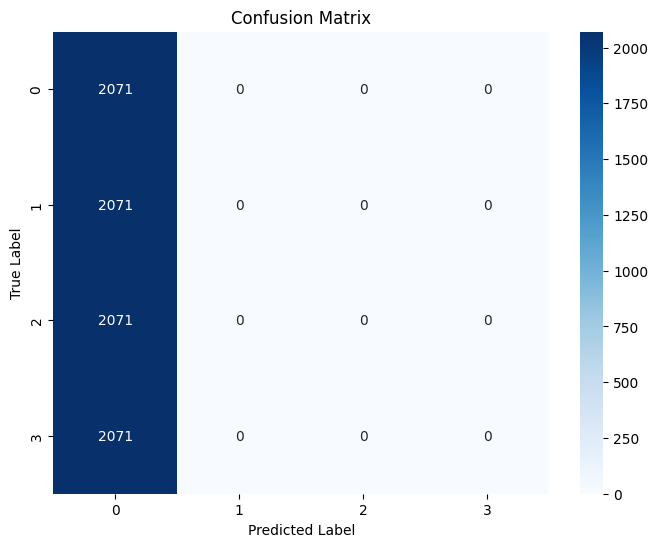

In [19]:
# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

# Calculate additional metrics
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
confusion = confusion_matrix(y_test, y_test_pred)

# Log confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(Path("../../../logs/IMG/XGB_V1_confusion_matrix.png")) # Save confusion matrix

# Print results
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Classification Report:\n{test_report}")

# Save the best model to disk
xgb_model_v1 = Path("../../../models/Map/xgb_model_v1.joblib")
joblib.dump(best_model, xgb_model_v1)
print(f"Saved model to: {xgb_model_v1}")

# Evaluate using cross-validation accuracy
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")

#### Predict New Images

In [20]:
# Load the best model
model = joblib.load(xgb_model_v1)

def predict_growth_stage(image_path, model):
    features = extract_features(image_path)
    predicted_label = model.predict([features])[0]
    return growth_stages[predicted_label]

new_image = Path('../../../data/model/Test/ripening/ripening_100FPLAN_31.tif')
predicted_stage = predict_growth_stage(new_image, model)
print(f"Predicted Growth Stage: {predicted_stage}")

Predicted Growth Stage: germination


c:\Users\user\anaconda3\envs\research_env\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
